# Loyola Supply Chain Data Analysis Competition

## Contributers:

    Aarij Rehman
    Charlie Marshall

## Loading Packages

In [1]:
import pandas as pd
import numpy as np
import datetime as dt
import matplotlib.pyplot as plt

## Loading in Data (Charlie):

Aarij will have to use different directories for his data.

In [343]:
FreightWaves=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/FreightWaves External Data.xlsx")

In [344]:
ShipperData=pd.read_excel("/Users/charlesmarshall/Desktop/Loyola-Supply-Chain-Competition/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [2]:
FreightWaves=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/FreightWaves External Data.xlsx")

In [3]:
ShipperData=pd.read_excel("/Users/aarij/Desktop/python-projects/loyola-supply-chain/Loyola 2nd Annual Data Competition - Shipper Data Set (Trailing 2-Years).xlsx")

In [5]:
ShipperData.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type
0,1046,2018-02-26,2018-02-26,2018-02-27,Atlanta,300,GA,NaN,217,MD,Temp Control,1316,Spot,1650.00,0,Ad-hoc
1,1223,2018-02-15,2018-02-16,2018-02-18,Chicago,463,IN,NaN,820,WY,Temp Control,1920,Spot,3480.00,0,Ad-hoc
2,1280,2018-02-15,2018-02-15,2018-02-19,Los Angeles,906,CA,NaN,554,MN,Dry Van,3816,Spot,3567.80,0,Ad-hoc
3,1282,2018-02-15,2018-02-16,2018-02-20,Chicago,601,IL,Chicago,606,IL,Dry Van,48,Spot,203.35,-42,Ad-hoc
4,1340,2018-02-16,2018-02-19,2018-02-19,Chicago,606,IL,Chicago,607,IL,Dry Van,42,Spot,343.88,0,Dedicated


## EDA

Understanding the data:

In [4]:
ShipperData['Book Date']=pd.to_datetime(ShipperData['Book Date'])
ShipperData['Pickup Date']=pd.to_datetime(ShipperData['Pickup Date'])
ShipperData['Delivery Date']=pd.to_datetime(ShipperData['Delivery Date'])

In [5]:
set(ShipperData['Origin Market'])

{'Atlanta', 'Chicago', 'Dallas', 'Los Angeles', 'Philadelphia', 'Seattle'}

In [6]:
set(ShipperData['Mode'])

{'Air',
 'Drayage',
 'Dry Van',
 'FlatBed',
 'Intermodal',
 'Ocean',
 'Other',
 'Reefer',
 'Temp Control',
 'Truck'}

In [7]:
set(ShipperData['Spot/Contract'])

{'Contract', 'Spot'}

In [8]:
set(ShipperData['Load Type'])

{'Ad-hoc', 'Consistent', 'Critical', 'Dedicated', 'Standard', 'White Glove'}

In [9]:
set(FreightWaves['index_name'])

{'DAT Longhaul Van Freight Rate',
 'Diesel Truck Stop Actual Price Per Gallon',
 'Headhaul Index',
 'Industrial Production',
 'Institute of Supply Management Metrics',
 'Intermodal Rates',
 'Orders',
 "Outbound Rail Volume 53' Containers (Loaded)",
 'Outbound Tender Reject Index',
 'Outbound Tender Volume Index',
 'Producer Price Index',
 'Retail Sales YoY Change',
 'TLT is now a legacy variable, refer to OTLT',
 'Total Construction Spending (000,000s)',
 'US Customs Maritime Import Shipments'}

## Preprocessing

Some preproccessing that needs to be done to the whole data set

### 7 FreightWaves Futures Lanes:
    VLS (LA -> Seattle)
    VSL (Seattle -> LA)
    VLD (LA -> Dallas)
    VDL (Dallas -> LA)
    VCA (Chicago -> Atlanta)
    VAP (Atlanta -> Philadelphia)
    VPC (Philadelphia -> Chicago)
    
    If the load is not delivered in one of these lanes, it will be marked 'Other'

# Charlie can you fix this part or remove idk what it does

In [10]:
# Categorizing the Future Lanes
Lane = []
org = list(ShipperData['Origin Market'])
dst = list(ShipperData['Dest Market'])
los = 'Los Angeles'
sea = 'Seattle'
dal = 'Dallas'
chi = 'Chicago'
atl = 'Atlanta'
phi = 'Philadelphia'

futures = {}
futures[(los, sea)] = 'VLS'
futures[(sea, los)] = 'VSL'
futures[(los, dal)] = 'VLD'
futures[(dal, los)] = 'VDL'
futures[(chi, atl)] = 'VCA'
futures[(atl, phi)] = 'VAP'
futures[(phi, chi)] = 'VPC'

In [11]:
Lane=[]
for i in range(len(org)):
    if (org[i], dst[i]) in futures:
        Lane.append(futures[(org[i], dst[i])])
    else:
        Lane.append('Other')

In [12]:
ShipperData['Lane'] = Lane

In [13]:
ShipperData.head()

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
0,1046,2018-02-26,2018-02-26,2018-02-27,Atlanta,300,GA,NaN,217,MD,Temp Control,1316,Spot,1650.00,0,Ad-hoc,Other
1,1223,2018-02-15,2018-02-16,2018-02-18,Chicago,463,IN,NaN,820,WY,Temp Control,1920,Spot,3480.00,0,Ad-hoc,Other
2,1280,2018-02-15,2018-02-15,2018-02-19,Los Angeles,906,CA,NaN,554,MN,Dry Van,3816,Spot,3567.80,0,Ad-hoc,Other
3,1282,2018-02-15,2018-02-16,2018-02-20,Chicago,601,IL,Chicago,606,IL,Dry Van,48,Spot,203.35,-42,Ad-hoc,Other
4,1340,2018-02-16,2018-02-19,2018-02-19,Chicago,606,IL,Chicago,607,IL,Dry Van,42,Spot,343.88,0,Dedicated,Other


## Questions to Ask:

#### Part 1    
    1) Does 2019 mean the book, pickup, or delivery date is in 2019? There are many times when the one of these three meaures are in another year while other measures are in 2019.
    2) When you say "Truckload" RPM", does this mean only for trucks and dry vans?
    3) How should we deal with instances where the mileage is 0 or blank? Outlier
    4) How would you define "volatility"? Does it have something to do with spot vs contract market prices and how they change? Maybe the spread of the prices?

## Question 1

    Calculating overall average Truckload rate per mile in 2019?  Hint: rate per mile is total revenue for a move divided by total mileage.  Please also note that “Dry Van” and “Truck” mean the same thing here:

    Steps:
    Year = 2019
    Truckload = "Dry Van" or "Truck" in Mode ??? NOT SURE IF "TRUCKLOAD" MEANS JUST THESE TWO ANYMORE ???
    Create column of Rate per mile (RPM), divide revenue by mileage for each truckload
    Sum the RPM column, divide by number of instances to find AVERAGE
    

### Converting all date columns to datetime

In [14]:
Shipper2019=ShipperData[ShipperData['Pickup Date'].dt.year == 2019]

In [15]:
Shipper2019

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
2492,147769,2018-12-31,2019-01-02,2019-01-04,Atlanta,310,GA,NaN,782,TX,Dry Van,2218,Spot,1836.00,0,Ad-hoc,Other
2532,147889,2018-12-19,2019-01-02,2019-01-11,Los Angeles,902,CA,NaN,482,MI,Intermodal,4600,Spot,4340.00,0,Ad-hoc,Other
2588,155164,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other
2589,155166,2019-01-08,2019-01-08,2019-01-10,Chicago,606,IL,NaN,154,MA,Dry Van,1898,Spot,2895.15,-11,Ad-hoc,Other
2590,155169,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111165,392783,2019-12-19,2019-12-26,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,581.90,100,Standard,Other
111166,392787,2019-12-19,2019-12-27,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,577.29,78,Standard,Other
111167,392794,2019-12-23,2019-12-30,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,572.47,78,Standard,Other
111255,393205,2019-12-19,2019-12-27,2020-01-17,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,581.34,90,Standard,Other


In [17]:
Q1=Shipper2019[Shipper2019['Mode'].isin(['Dry Van','Truck'])].copy()

In [18]:
Q1

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
2492,147769,2018-12-31,2019-01-02,2019-01-04,Atlanta,310,GA,NaN,782,TX,Dry Van,2218,Spot,1836.00,0,Ad-hoc,Other
2588,155164,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other
2589,155166,2019-01-08,2019-01-08,2019-01-10,Chicago,606,IL,NaN,154,MA,Dry Van,1898,Spot,2895.15,-11,Ad-hoc,Other
2590,155169,2019-01-03,2019-01-05,2019-01-07,Chicago,609,IL,NaN,404,KY,Dry Van,764,Spot,1266.34,0,Consistent,Other
2591,155170,2019-01-04,2019-01-04,2019-01-07,Los Angeles,906,CA,Seattle,985,WA,Dry Van,2214,Spot,3525.00,0,Ad-hoc,VLS
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
111165,392783,2019-12-19,2019-12-26,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,581.90,100,Standard,Other
111166,392787,2019-12-19,2019-12-27,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,577.29,78,Standard,Other
111167,392794,2019-12-23,2019-12-30,2020-01-16,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,572.47,78,Standard,Other
111255,393205,2019-12-19,2019-12-27,2020-01-17,Chicago,600,IL,Chicago,608,IL,Truck,56.1,Spot,581.34,90,Standard,Other


In [19]:
Q1=Q1.reset_index(drop=True)

In [20]:
Q1[Q1['Mileage']==0]

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
39,155407,2019-01-04,2019-01-04,2019-01-07,Chicago,608,IL,Chicago,608,IL,Dry Van,0,Spot,250.54,-5,Dedicated,Other
61,138663,2019-01-02,2019-01-02,2019-01-31,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other
62,138664,2019-01-02,2019-01-02,2019-01-31,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other
64,141319,2019-01-03,2019-01-06,2019-02-06,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,575.00,575,Ad-hoc,Other
65,141320,2019-01-03,2019-01-06,2019-02-06,Chicago,605,IL,Chicago,605,IL,Dry Van,0,Spot,450.00,450,Ad-hoc,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43066,389764,2020-01-06,2019-12-30,2020-01-03,Chicago,608,IL,Chicago,608,IL,Truck,0,Contract,2784.02,0,Consistent,Other
43067,389860,2019-12-06,2019-12-06,2020-01-06,Chicago,605,IL,Chicago,605,IL,Truck,0,Contract,575.00,0,Standard,Other
43068,389861,2019-12-06,2019-12-06,2020-01-06,Chicago,605,IL,Chicago,605,IL,Truck,0,Contract,450.00,0,Standard,Other
43095,392264,2019-12-12,2019-12-15,2020-01-15,Chicago,600,IL,Chicago,600,IL,Truck,0,Contract,0.00,0,Standard,Other


In [21]:
Q1[Q1['Revenue']==0]

,Load Number,Book Date,Pickup Date,Delivery Date,Origin Market,3-Digit Origin #,Origin State,Dest Market,3-Digit Dest #,Dest State,Mode,Mileage,Spot/Contract,Revenue,Accessorial Cost,Load Type,Lane
240,152630,2019-03-04,2019-01-02,2019-01-03,Los Angeles,917,CA,NaN,953,CA,Dry Van,(blank),Spot,0.0,0,Ad-hoc,Other
421,154220,2019-01-02,2019-01-02,2019-01-02,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other
422,154222,2019-01-02,2019-01-03,2019-01-03,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other
423,154224,2019-01-02,2019-01-04,2019-01-04,Chicago,600,IL,Chicago,601,IL,Dry Van,44,Spot,0.0,0,Ad-hoc,Other
425,154256,2019-01-02,2019-01-02,2019-01-02,Chicago,601,IL,Chicago,601,IL,Dry Van,0,Spot,0.0,-1,Ad-hoc,Other
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
38039,364709,2019-11-11,2019-11-11,2019-11-12,Chicago,601,IL,Chicago,601,IL,Truck,0,Spot,0.0,0,Standard,Other
38040,364710,2019-11-11,2019-11-11,2019-11-12,Chicago,601,IL,Chicago,601,IL,Truck,0,Spot,0.0,0,Standard,Other
38609,367367,2019-11-14,2019-11-14,2019-11-15,Chicago,601,IL,Chicago,601,IL,Truck,0,Spot,0.0,0,Standard,Other
39801,373387,2019-11-25,2019-11-25,2019-11-26,Chicago,601,IL,Atlanta,301,GA,Truck,737.1,Contract,0.0,-1,Standard,VCA


In [22]:
Q1['Revenue'][43095]/Q1['Mileage'][43095]

/Users/aarij/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in double_scalars
  """Entry point for launching an IPython kernel.


nan

In [23]:
rpm=np.empty(len(Q1))

In [24]:
for i in range(len(Q1)):
    if Q1['Mileage'][i]==0:
        rpm[i]=12345
    else:
        try:
            rpm[i]= Q1['Revenue'][i]/Q1['Mileage'][i]
        except TypeError:
            rpm[i]=54321

In [25]:
# 762 (out of 43,000) instances where the revenue is 0
len(rpm[rpm==12345])

762

In [26]:
for i in range(len(Q1)):
    if Q1['Mileage'][i]==0:
        rpm[i]=0
    else:
        try:
            rpm[i]= Q1['Revenue'][i]/Q1['Mileage'][i]
        except TypeError:
            rpm[i]=0

In [27]:
Q1['RPM'] = rpm

In [28]:
Average2019RPM=sum(Q1['RPM'])/len(Q1)

In [29]:
Average2019RPM

3.605813503312686

### Question 1a

    Using this Redwood rate per mile data, rank the 7 FreightWaves Futures lanes (page 2 at link) by rate volatility for full year 2019.
    
    Volatility = sd
    So, the Futures lanes will be ranked by sd of RPM data. Highest to lowest.

In [30]:
LaneVolitility2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].std(),columns=['RPM']).drop(['Other']).sort_values(by=['RPM'],ascending=False)

In [31]:
LaneVolitility2019

,RPM
Lane,
VPC,5.410751
VCA,1.275223
VLS,0.789660
VAP,0.625256
VLD,0.552769
VDL,0.357352
VSL,0.296679


### Question 1b

    Rank these lanes by total Redwood Truckload volume for full year 2019.
    
    Defining "volume" as the number (count) of truckloads delivered in each lane in 2019.

In [32]:
LaneVolume2019=pd.DataFrame(Q1.groupby('Lane')['RPM'].count()).drop(['Other']).sort_values(by=['RPM'],ascending=False).rename(columns={'RPM':'Volume'})

In [33]:
LaneVolume2019

,Volume
Lane,
VCA,396
VSL,275
VDL,198
VPC,197
VLS,174
VLD,107
VAP,40


In [34]:
Shipper2019['Lane'].value_counts()

Other    48923
VCA        480
VSL        291
VDL        258
VPC        230
VLS        187
VLD        136
VAP         42
Name: Lane, dtype: int64

## Question 2

    Rank the lanes provided in the FreightWaves data by total intermodal volume for full year 2019.

In [35]:
Q2=Shipper2019[Shipper2019['Mode'].isin(['Intermodal'])]

In [36]:
Q2=Q2.reset_index(drop=True)

In [37]:
IntermodalLaneVolume2019=pd.DataFrame(Q2.groupby('Lane')['Load Number'].count()).drop(['Other']).sort_values(by=['Load Number'],ascending=False).rename(columns={'RPM':'Volume'})

In [38]:
IntermodalLaneVolume2019

,Load Number
Lane,
VDL,47
VLD,29
VCA,1


## Question 3

    Graph monthly volatility in fuel prices by markets provided in the FreightWaves data.  Do any markets stand out to you in particular?

In [39]:
FreightWaves['data_timestamp']=pd.to_datetime(FreightWaves['data_timestamp'])

In [40]:
FreightWaves.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,COSP,RES,COSP.RES,2019-04-30,512113.0,"Total Construction Spending (000,000s)",Residential
1,COSP,RES,COSP.RES,2019-09-30,529455.0,"Total Construction Spending (000,000s)",Residential
2,COSP,RES,COSP.RES,2019-11-30,540457.0,"Total Construction Spending (000,000s)",Residential
3,COSP,RES,COSP.RES,2018-02-28,577315.0,"Total Construction Spending (000,000s)",Residential
4,COSP,RES,COSP.RES,2018-12-31,517951.0,"Total Construction Spending (000,000s)",Residential


In [41]:
set(FreightWaves['ticker'])

{'COSP',
 'CSTM',
 'DATVF',
 'DTS',
 'HAUL',
 'INTRM',
 'IPRO',
 'ISM',
 'ORAIL53L',
 'ORDERS',
 'OTRI',
 'OTVI',
 'PPI',
 'RESLG',
 'TLT'}

In [42]:
Q3=FreightWaves[FreightWaves['ticker']=='DTS']

In [43]:
Q3=Q3.reset_index(drop=True)

In [44]:
Q3.head()

,ticker,granularity1,symbol,data_timestamp,data_value,index_name,Description
0,DTS,ATL,DTS.ATL,2018-03-13,2.777,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
1,DTS,ATL,DTS.ATL,2018-03-16,2.828,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
2,DTS,ATL,DTS.ATL,2018-03-27,2.921,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
3,DTS,ATL,DTS.ATL,2018-03-29,2.952,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"
4,DTS,ATL,DTS.ATL,2018-04-02,2.915,Diesel Truck Stop Actual Price Per Gallon,"Atlanta, GA"


In [45]:
set(Q3['Description'])

{'Atlanta, GA',
 'Chicago, IL',
 'Dallas, TX',
 'Los Angeles, CA',
 'Philadelphia, PA',
 'Seattle, WA'}

In [46]:
set(Q3['granularity1'])

{'ATL', 'CHI', 'DAL', 'LAX', 'PHL', 'SEA'}

In [47]:
per = Q3.data_timestamp.dt.to_period("M")

In [48]:
DTS_Monthly_Volatility=Q3.groupby(['granularity1',per]).std()

In [49]:
months=['2018-03','2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12','2020-01','2020-02']
y_atl=DTS_Monthly_Volatility['data_value'][0:24]
y_chi=DTS_Monthly_Volatility['data_value'][24:48]
y_dal=DTS_Monthly_Volatility['data_value'][48:72]
y_lax=DTS_Monthly_Volatility['data_value'][72:96]
y_phl=DTS_Monthly_Volatility['data_value'][96:120]
y_sea=DTS_Monthly_Volatility['data_value'][120:144]

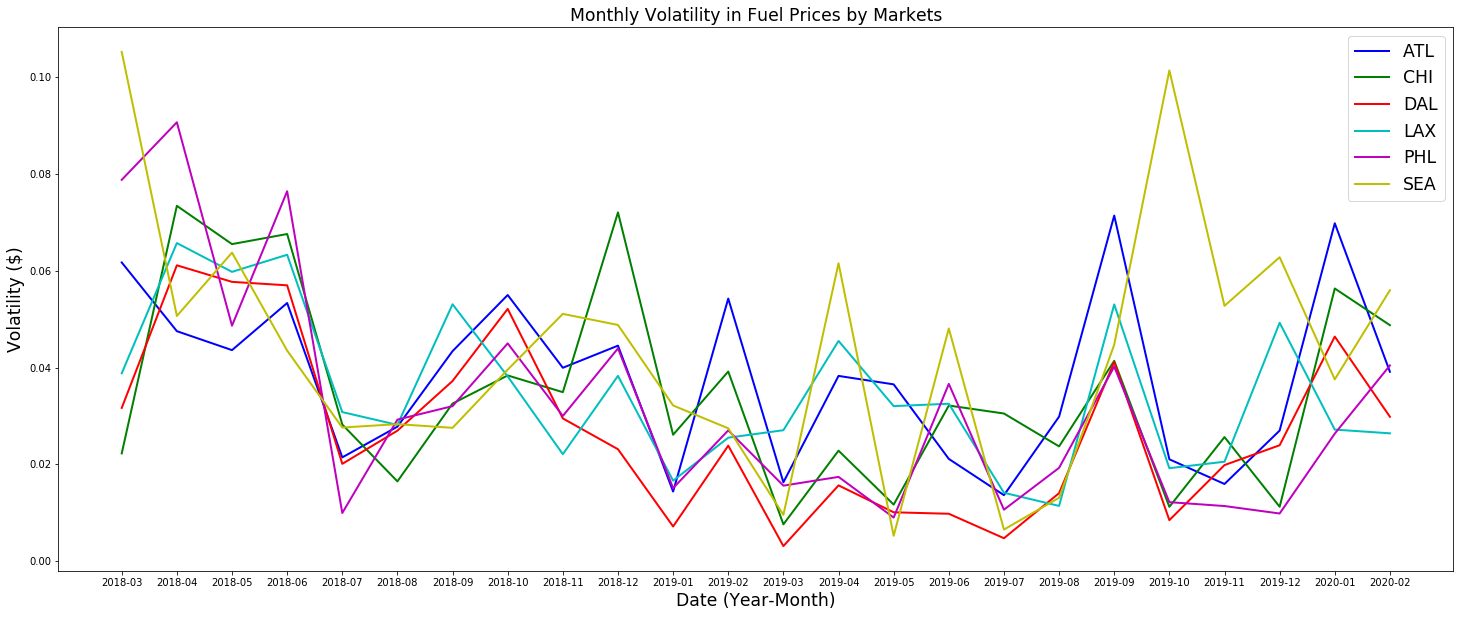

In [50]:
fig = plt.figure(figsize=(25,10))
plt.plot( months, y_atl, marker='', color='b', linewidth=2,label="ATL")
plt.plot( months, y_chi, marker='', color='g', linewidth=2,label="CHI")
plt.plot( months, y_dal, marker='', color='r', linewidth=2,label="DAL")
plt.plot( months, y_lax, marker='', color='c', linewidth=2,label="LAX")
plt.plot( months, y_phl, marker='', color='m', linewidth=2,label="PHL")
plt.plot( months, y_sea, marker='', color='y', linewidth=2,label="SEA")
plt.title('Monthly Volatility in Fuel Prices by Markets',fontsize='xx-large')
plt.ylabel('Volatility ($)',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')

## Question 4

    Briefly explain how the mixture of spot and contract (% of total volume) of Dry-Van freight in the Redwood Data varied throughout 2018-2019.  What factors do you think would cause a shipper to sign a forward-looking Truckload rate contract or rely on the spot market?

In [126]:
Shipper2019 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2019) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]
Shipper2018 = ShipperData[(ShipperData['Pickup Date'].dt.year == 2018) & (ShipperData['Mode'].isin(['Dry Van', 'Truck']))]

In [127]:
spot18 = []
spot19 = []
for month in range(1, 13):
    spot18.append(Shipper2018[Shipper2018['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
    spot19.append(Shipper2019[Shipper2019['Pickup Date'].dt.month == month]['Spot/Contract'].value_counts(normalize=True)['Spot'])
spot = spot18 + spot19

In [128]:
cont = [1-i for i in spot]

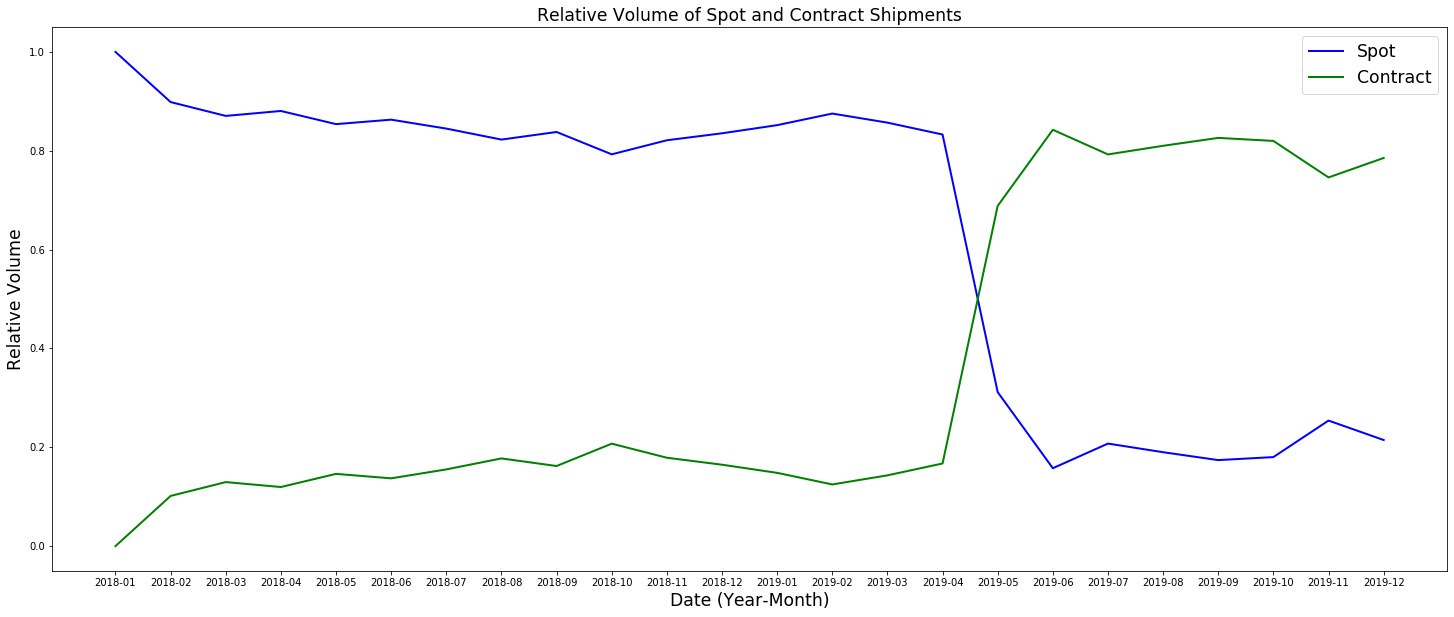

In [129]:
months=['2018-01', '2018-02', '2018-03', '2018-04','2018-05','2018-06','2018-07','2018-08','2018-09','2018-10','2018-11','2018-12','2019-01','2019-02','2019-03','2019-04','2019-05','2019-06','2019-07','2019-08','2019-09','2019-10','2019-11','2019-12']

fig = plt.figure(figsize=(25,10))
plt.plot(months, spot, marker='', color='b', linewidth=2,label="Spot")
plt.plot(months, cont, marker='', color='g', linewidth=2,label="Contract")

plt.title('Relative Volume of Spot and Contract Shipments',fontsize='xx-large')
plt.ylabel('Relative Volume',fontsize='xx-large')
plt.xlabel('Date (Year-Month)',fontsize='xx-large')
plt.legend(fontsize='xx-large')